# Intraquarter variability exploration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
import pandas as pd
from astropy.io import fits
import lightkurve as lk
%config InlineBackend.figure_format='retina'

In [2]:
sr = lk.search_lightcurve('KIC 5818116')

In [3]:
lcs_raw = sr.download_all()

In [4]:
#lcs =  lk.LightCurveCollection([lc.SAP_FLUX.normalize() for lc in lcs_raw])
lcs =  lk.LightCurveCollection([lc.PDCSAP_FLUX.normalize() for lc in lcs_raw])

/var/folders/gb/yvbtr8b57pd1nzzxk3t_zwfsxgvdgb/T/ipykernel_98972/1081608470.py:2: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lcs =  lk.LightCurveCollection([lc.PDCSAP_FLUX.normalize() for lc in lcs_raw])


### Fetch the `f3` photometry for this source

In [5]:
times = np.array([54945.74206,54945.8670833,54946.0182163,54946.2335259,54946.3377372,54946.5495655,
                  54946.7334679,54947.1662509,55062.8253608,55091.0055606,55123.0864583,55153.9797114,
                  55182.0366329,55215.9548927,55216.0352649,55245.7660019,55274.7398619,55307.5350333,
                  55336.4281441,55370.695297,55399.0571196,55430.8109392,55461.8291274,55492.8064711,
                  55522.7621353,55552.0843583,55585.5760016,55614.7389024,55677.4444762,55706.6440223,
                  55738.4591443,55769.477399,55801.7624176,55832.8010616,55864.8001316,55895.757043,
                  55930.8619526,55958.4268791,55986.5230115,56014.5579184,56047.5173675,56077.4525238,
                  56105.5895974,56137.5273556,56168.8315615,56203.8547584,56236.834641,56267.9141396,
                  56303.6729488,56330.563549,56357.495041,56390.4952381])

ffidata = pd.read_csv('../../data/f3/lc_data_new.out')

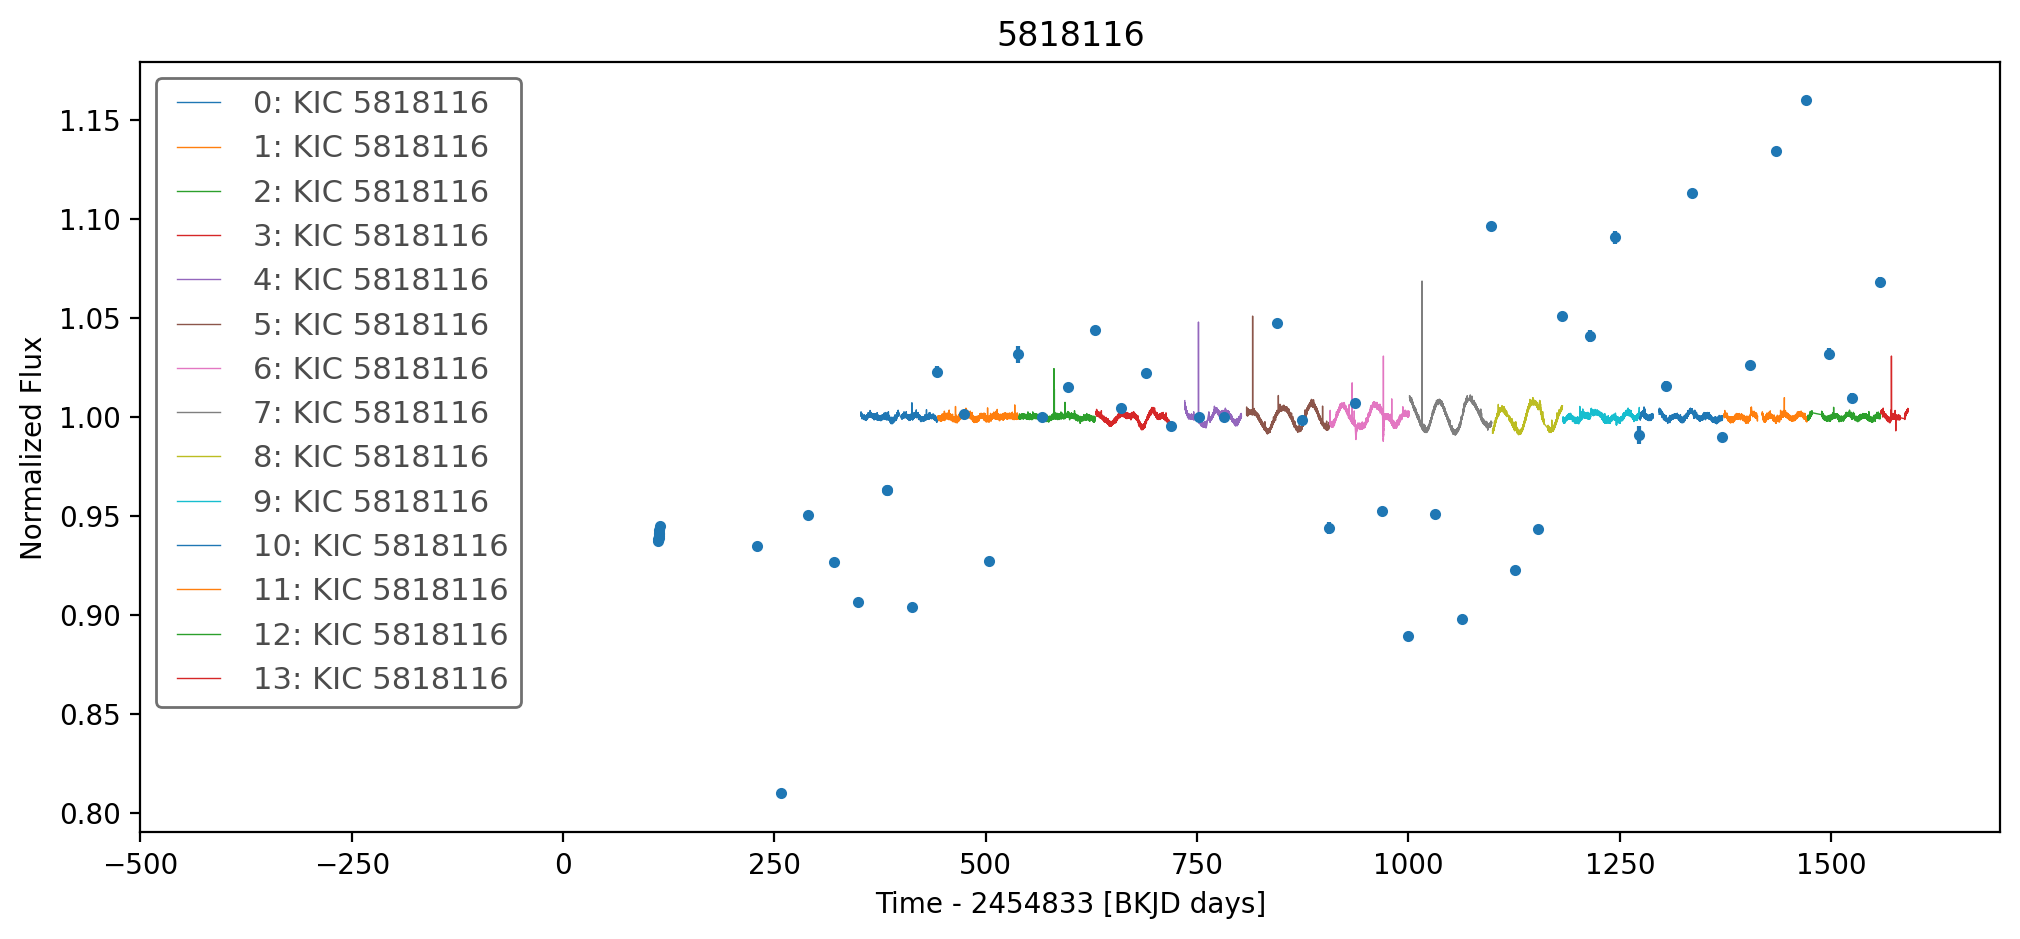

In [133]:
kepid = 5818116
flux = ffidata[ffidata['KIC'] == kepid].iloc[:,1:53]
yerr = ffidata[ffidata['KIC'] == kepid].iloc[:,-52:]

fig, ax = plt.subplots(figsize=(12,5))
ax.errorbar(times-54833, np.asarray(flux)[0], yerr=np.asarray(yerr)[0], fmt='.')
ax.set_xlabel('Time')
ax.set_ylabel('Normalised Flux')
ax.set_title(kepid)

lcs.plot(ax=ax)
ax.set_xlim(-500,1700);


In [139]:
flux.values

array([[0.93761956, 0.93826833, 0.93902859, 0.94000496, 0.94070092,
        0.94149107, 0.94282779, 0.94520568, 0.93505765, 0.80997872,
        0.95057401, 0.9266306 , 0.90672707, 0.9630315 , 0.96336238,
        0.90418679, 1.02304178, 1.00138131, 0.92714986, 1.03164734,
        1.        , 1.01540184, 1.04414258, 1.00466134, 1.02227344,
        0.99533866, 0.99982862, 1.00017138, 1.04753322, 0.99861869,
        0.94397311, 1.00720926, 0.95267262, 0.88962366, 0.95101742,
        0.89810172, 1.09648648, 0.92285212, 0.94346088, 1.05085509,
        1.04100622, 1.09092817, 0.99099435, 1.01565732, 1.11347337,
        0.98978506, 1.02628976, 1.13429086, 1.16005932, 1.03211473,
        1.00989369, 1.06832929]])

In [140]:
lc_f3 = lk.LightCurve(time=times, flux=flux.values[0], flux_err=yerr.values[0])

In [142]:
pg = lc_f3.to_periodogram()

In [144]:
pg.period_at_max_power

<Quantity 802.6406545 d>

### Let's compute the amplitude in each quarter

Let's fit a sine wave with a design matrix:

$f_\mathrm{model} = A\sin{\frac{2\pi t}{P}} + B\cos{\frac{2\pi t}{P}} + Ct +Dt^2+Et^3$ 

In [8]:
lc = lcs[0]

In [29]:
pg = lcs.stitch().to_periodogram()
period_global = pg.period_at_max_power.value

In [18]:
periods

[17.27020922615618,
 18.930509817012354,
 44.913348754318584,
 37.23006231602388,
 41.850287227857734,
 34.78239417873608,
 38.91783526811196,
 37.34467591090483,
 37.54185035433197,
 45.14999141180669,
 19.432564327110594,
 18.079151819899078,
 17.16822427905863,
 158.7752072364674]

In [68]:
lc = lcs[0].remove_nans()

In [49]:
time_vector = lc.time.value

In [56]:
df_dm = pd.DataFrame({'sine_term':np.sin(2.0*np.pi*time_vector/period_global),
              'cos_term':np.cos(2.0*np.pi*time_vector/period_global),
              'linear':time_vector,
              'quadratic':time_vector**2,
              'order3':time_vector**3})
dm = lk.DesignMatrix(df_dm)

In [51]:
corrector = RegressionCorrector(lc)

In [58]:
lc_out = corrector.correct(dm)

In [96]:
thing = float(np.std(lc.remove_nans().flux.value))

In [100]:
stds = [float(np.std(lc.remove_nans().flux.value)) for lc in lcs]
avg_time = [float(np.mean(lc.remove_nans().time.value)) for lc in lcs]

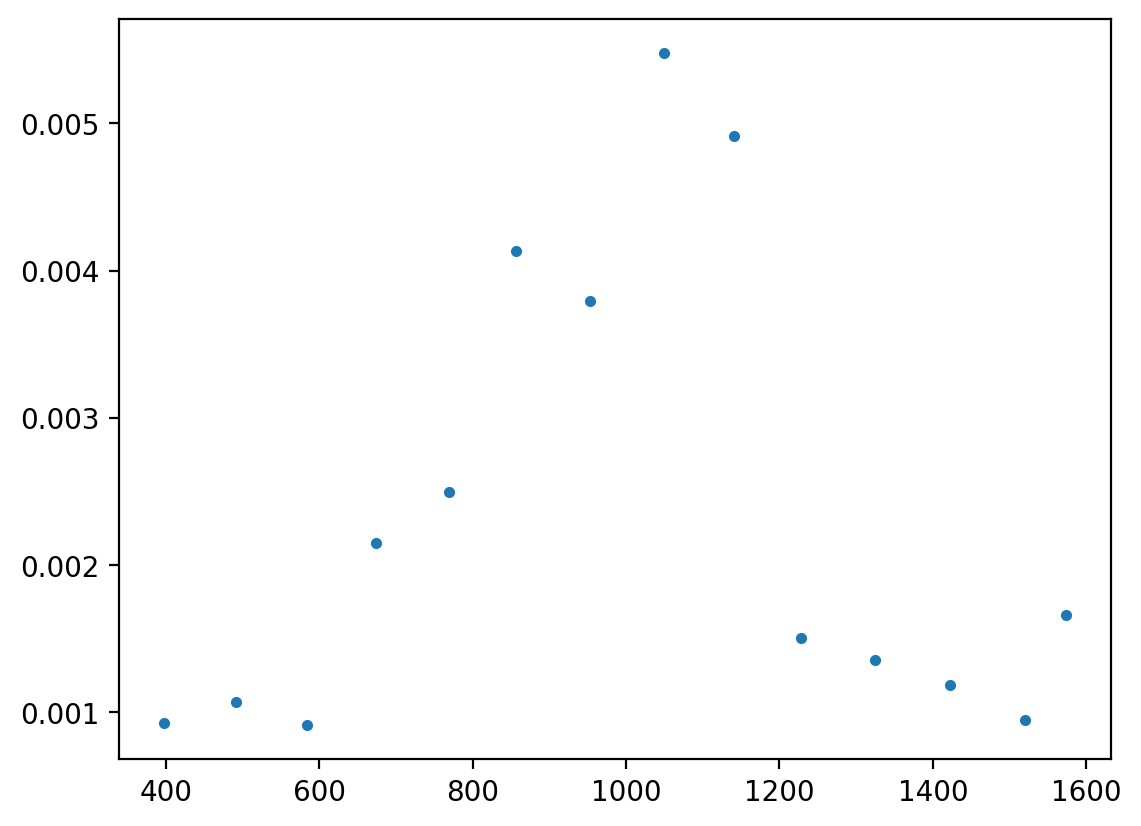

In [103]:
plt.plot(avg_time, stds, '.')

In [104]:
from scipy.stats import binned_statistic

In [119]:
avg_time.insert(0, 300)

In [120]:
result = binned_statistic(times-54833, flux, statistic='mean', bins=avg_time)

In [121]:
f3_quarter_means = result.statistic

In [122]:
stds

[0.0009275088086724281,
 0.001072516432031989,
 0.0009132911218330264,
 0.002146900864318013,
 0.00249255308881402,
 0.004136362578719854,
 0.003792266361415386,
 0.005478476174175739,
 0.004913623444736004,
 0.0015062959864735603,
 0.0013529090210795403,
 0.0011876088101416826,
 0.0009487306233495474,
 0.0016599239315837622]

In [125]:
f3_quarter_means[0]

array([0.93993789, 0.97620329, 0.98626573, 1.02140192, 1.00581358,
       1.0238523 , 0.98326702, 0.93110457, 0.97248011, 1.01177407,
       1.03252662, 1.04318273, 1.10882164, 1.03911149])

(0.0, 0.005706735426792875)

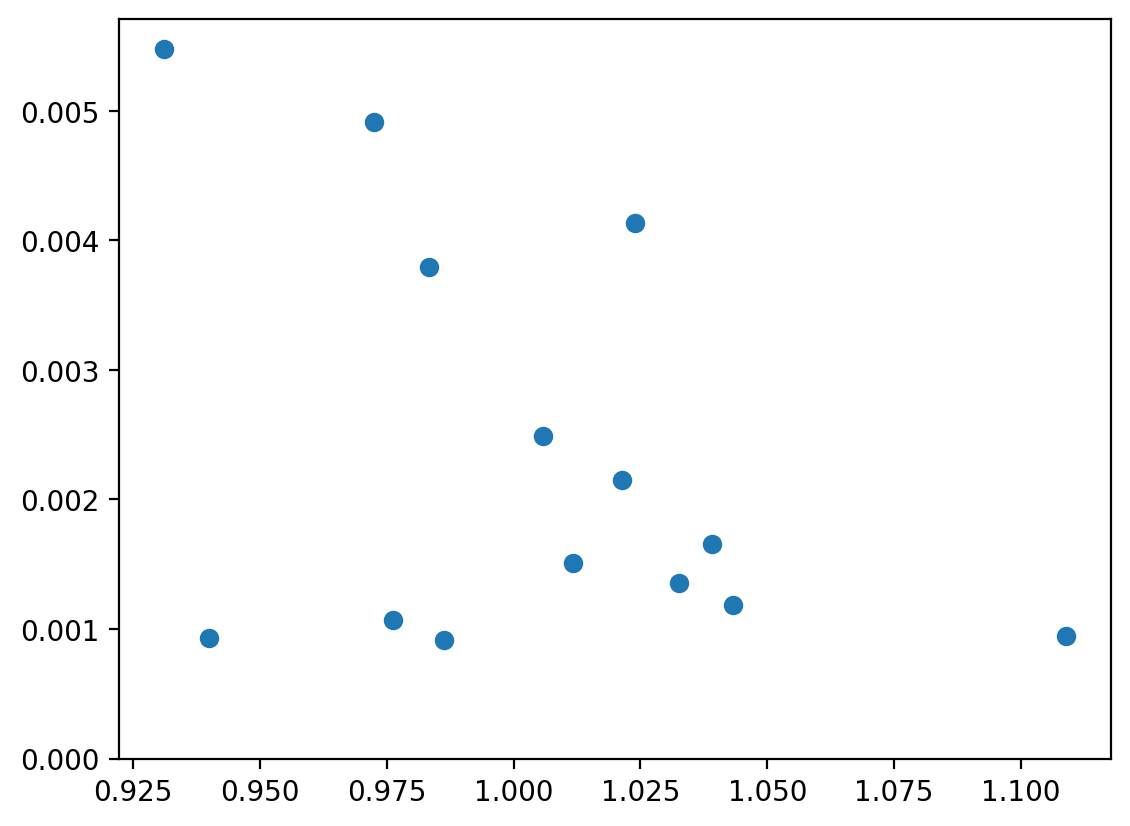

In [128]:
plt.plot(f3_quarter_means[0], stds, 'o')
plt.ylim(0)

In [ ]:
lc.bin()